## Get the Data

### Imports and workspace setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


### Load train/test CSV files

In [2]:
train = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col=0)
test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col=0)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Concatenating train/test data (X) and target (y)

In [3]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)
y = train[['SalePrice']]

## Discover and Visualize the Data

### Numeric vs categorical separation

In [4]:
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [6]:
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [7]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']   #MSSubClass is nominal
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

### Continuous numeric distributions

<ipython-input-8-53d116a9ebc0>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numeric_.loc[:,col].dropna(), kde=False)


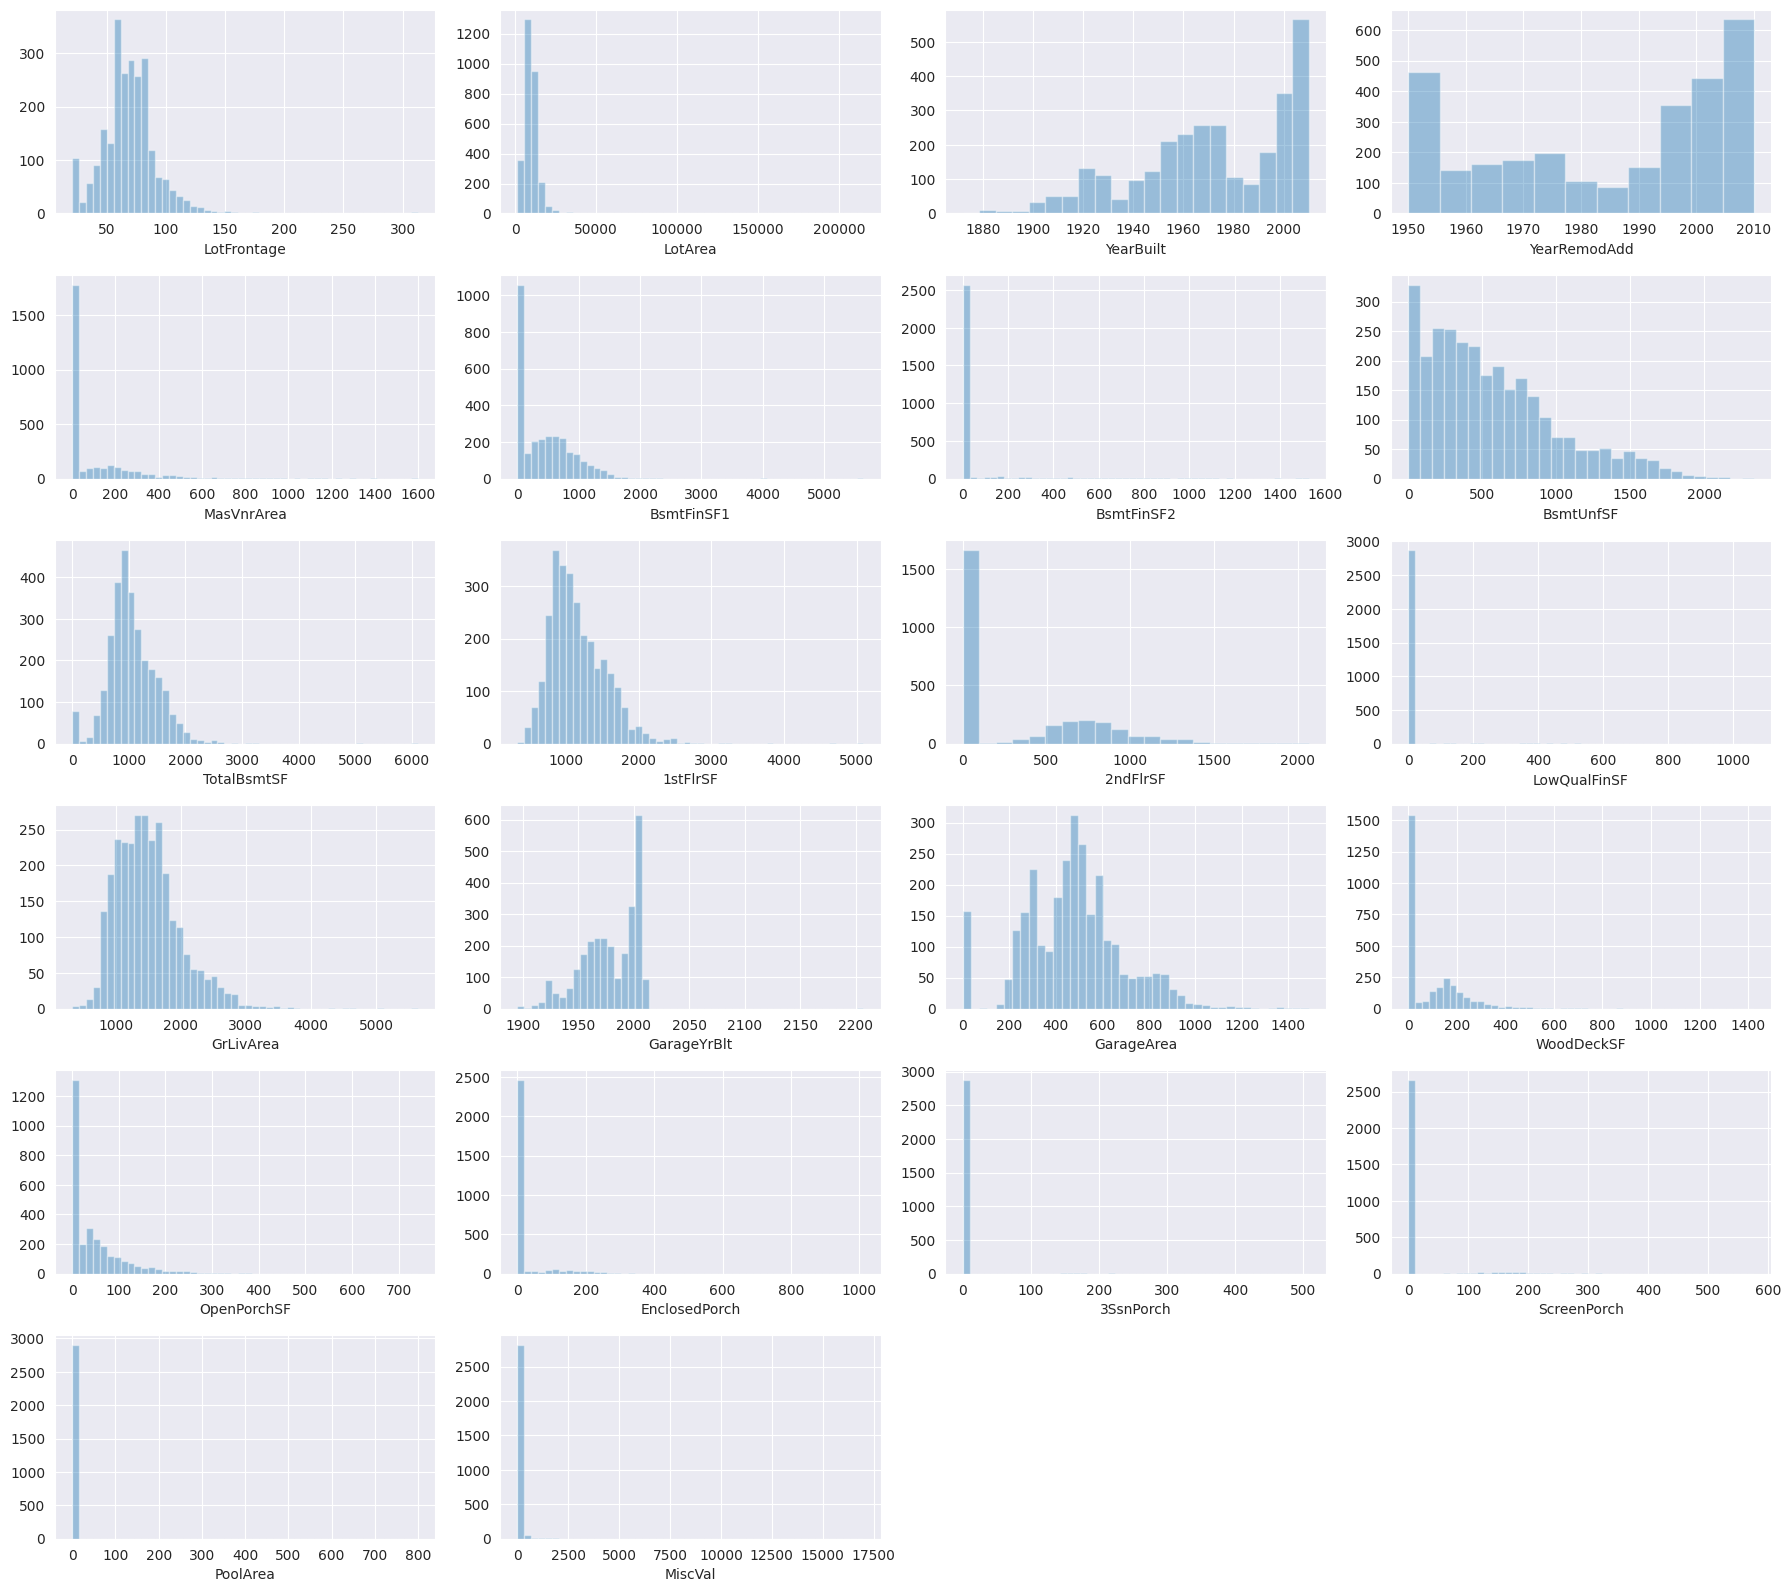

In [8]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(numeric_.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

### Discrete numeric counts 

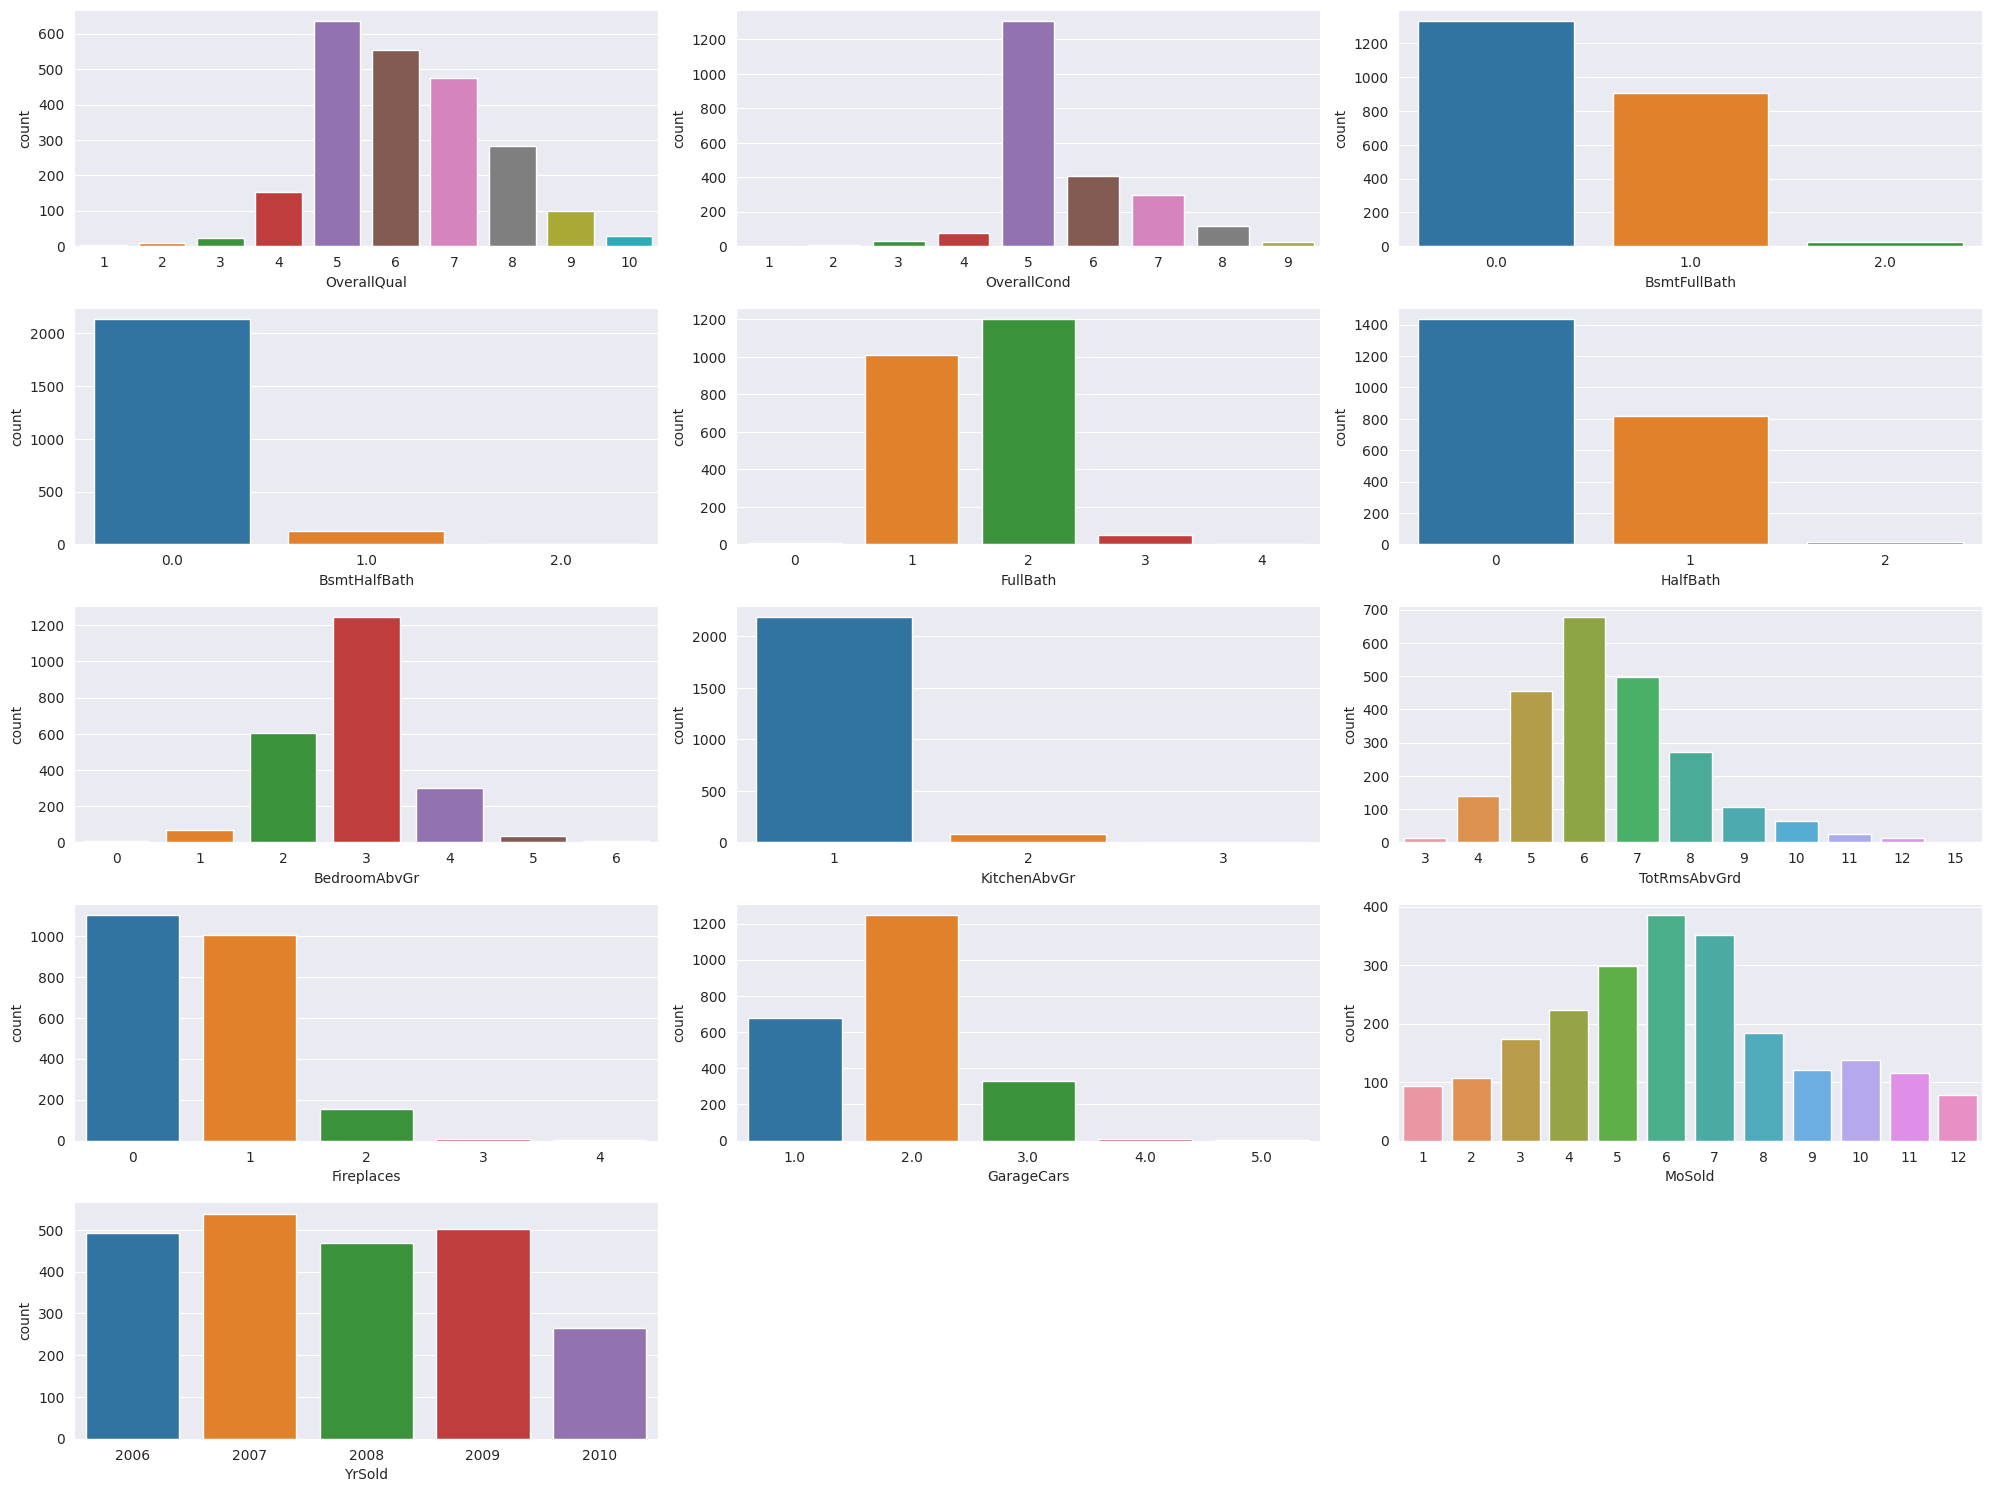

In [9]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

### Categorical feature counts

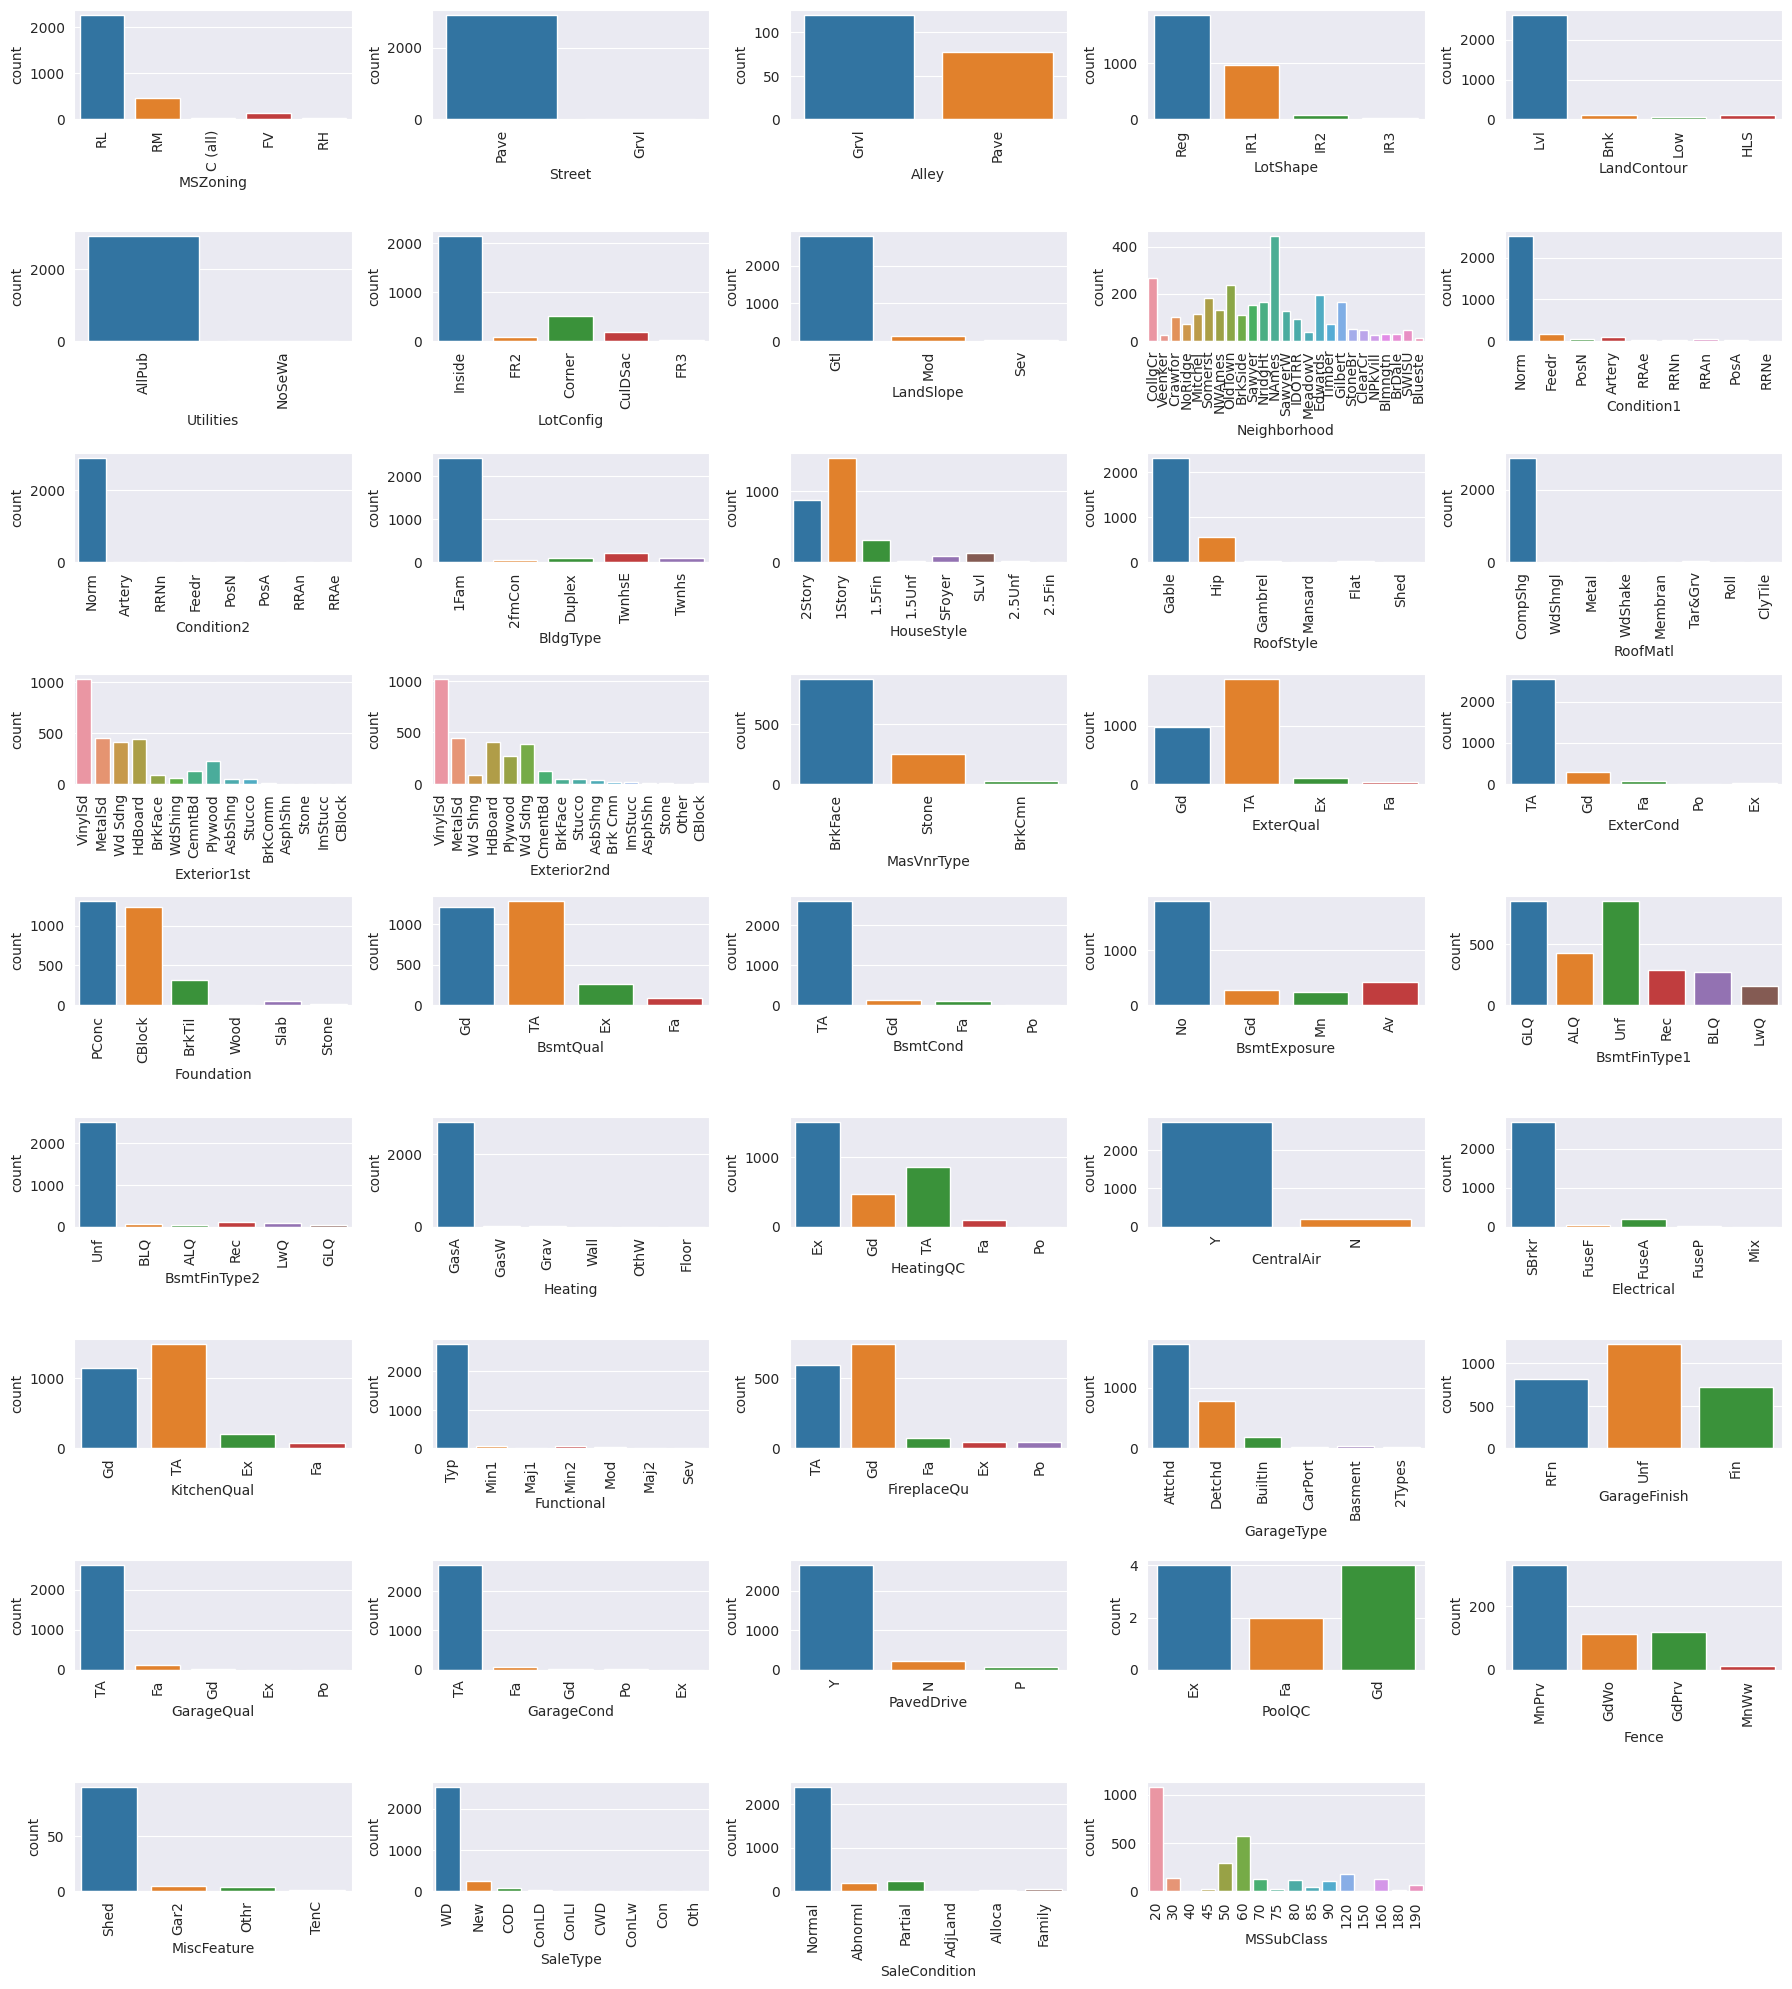

In [10]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

### Correlation heatmap

<Axes: >

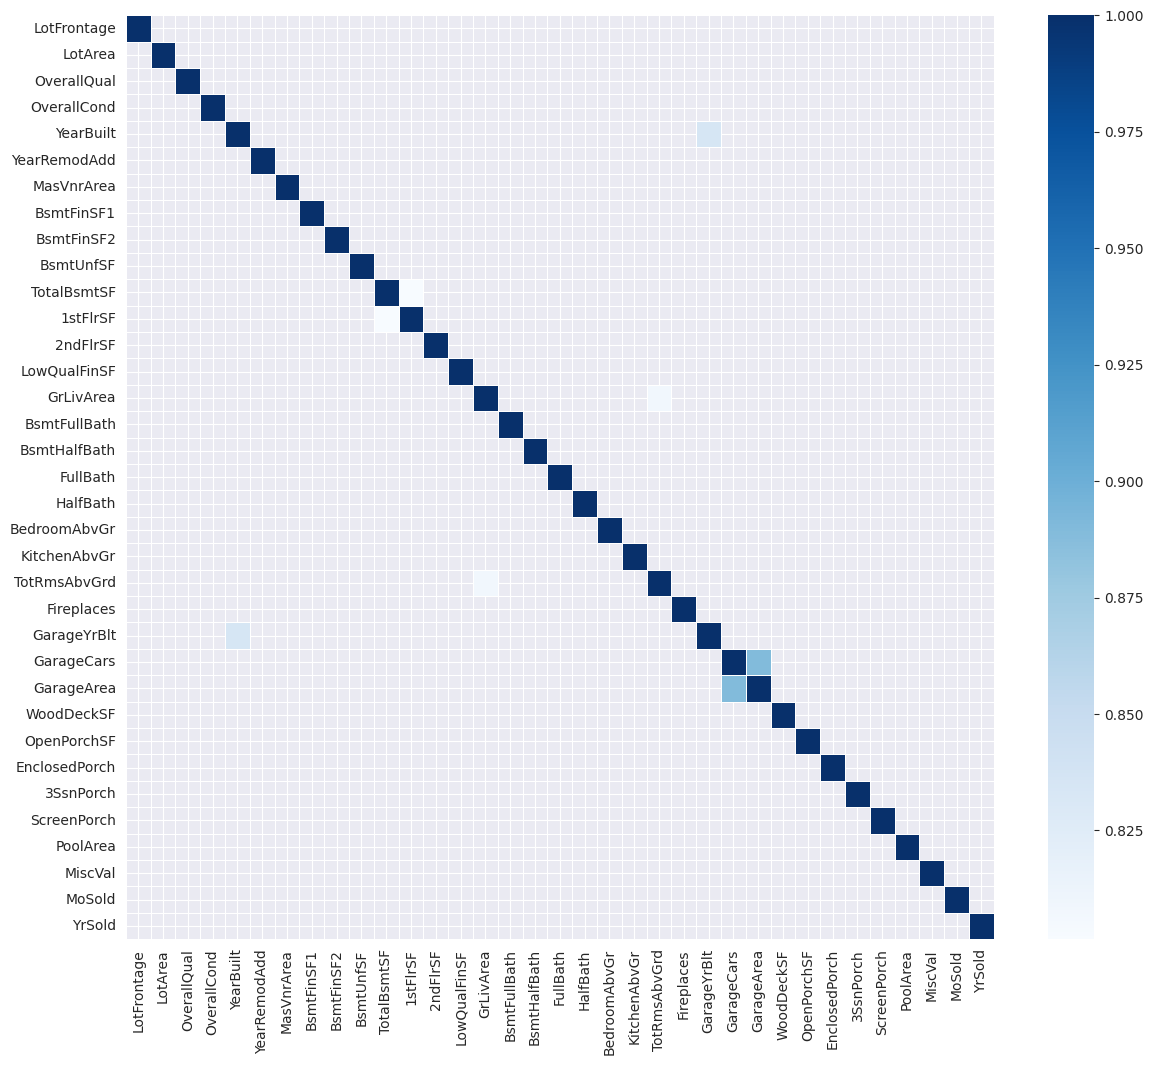

In [11]:
plt.figure(figsize=(14,12))
correlation = numeric_.corr()
correlation
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

### SalePrice correlation analysis

In [12]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Scatterplots vs SalePrice

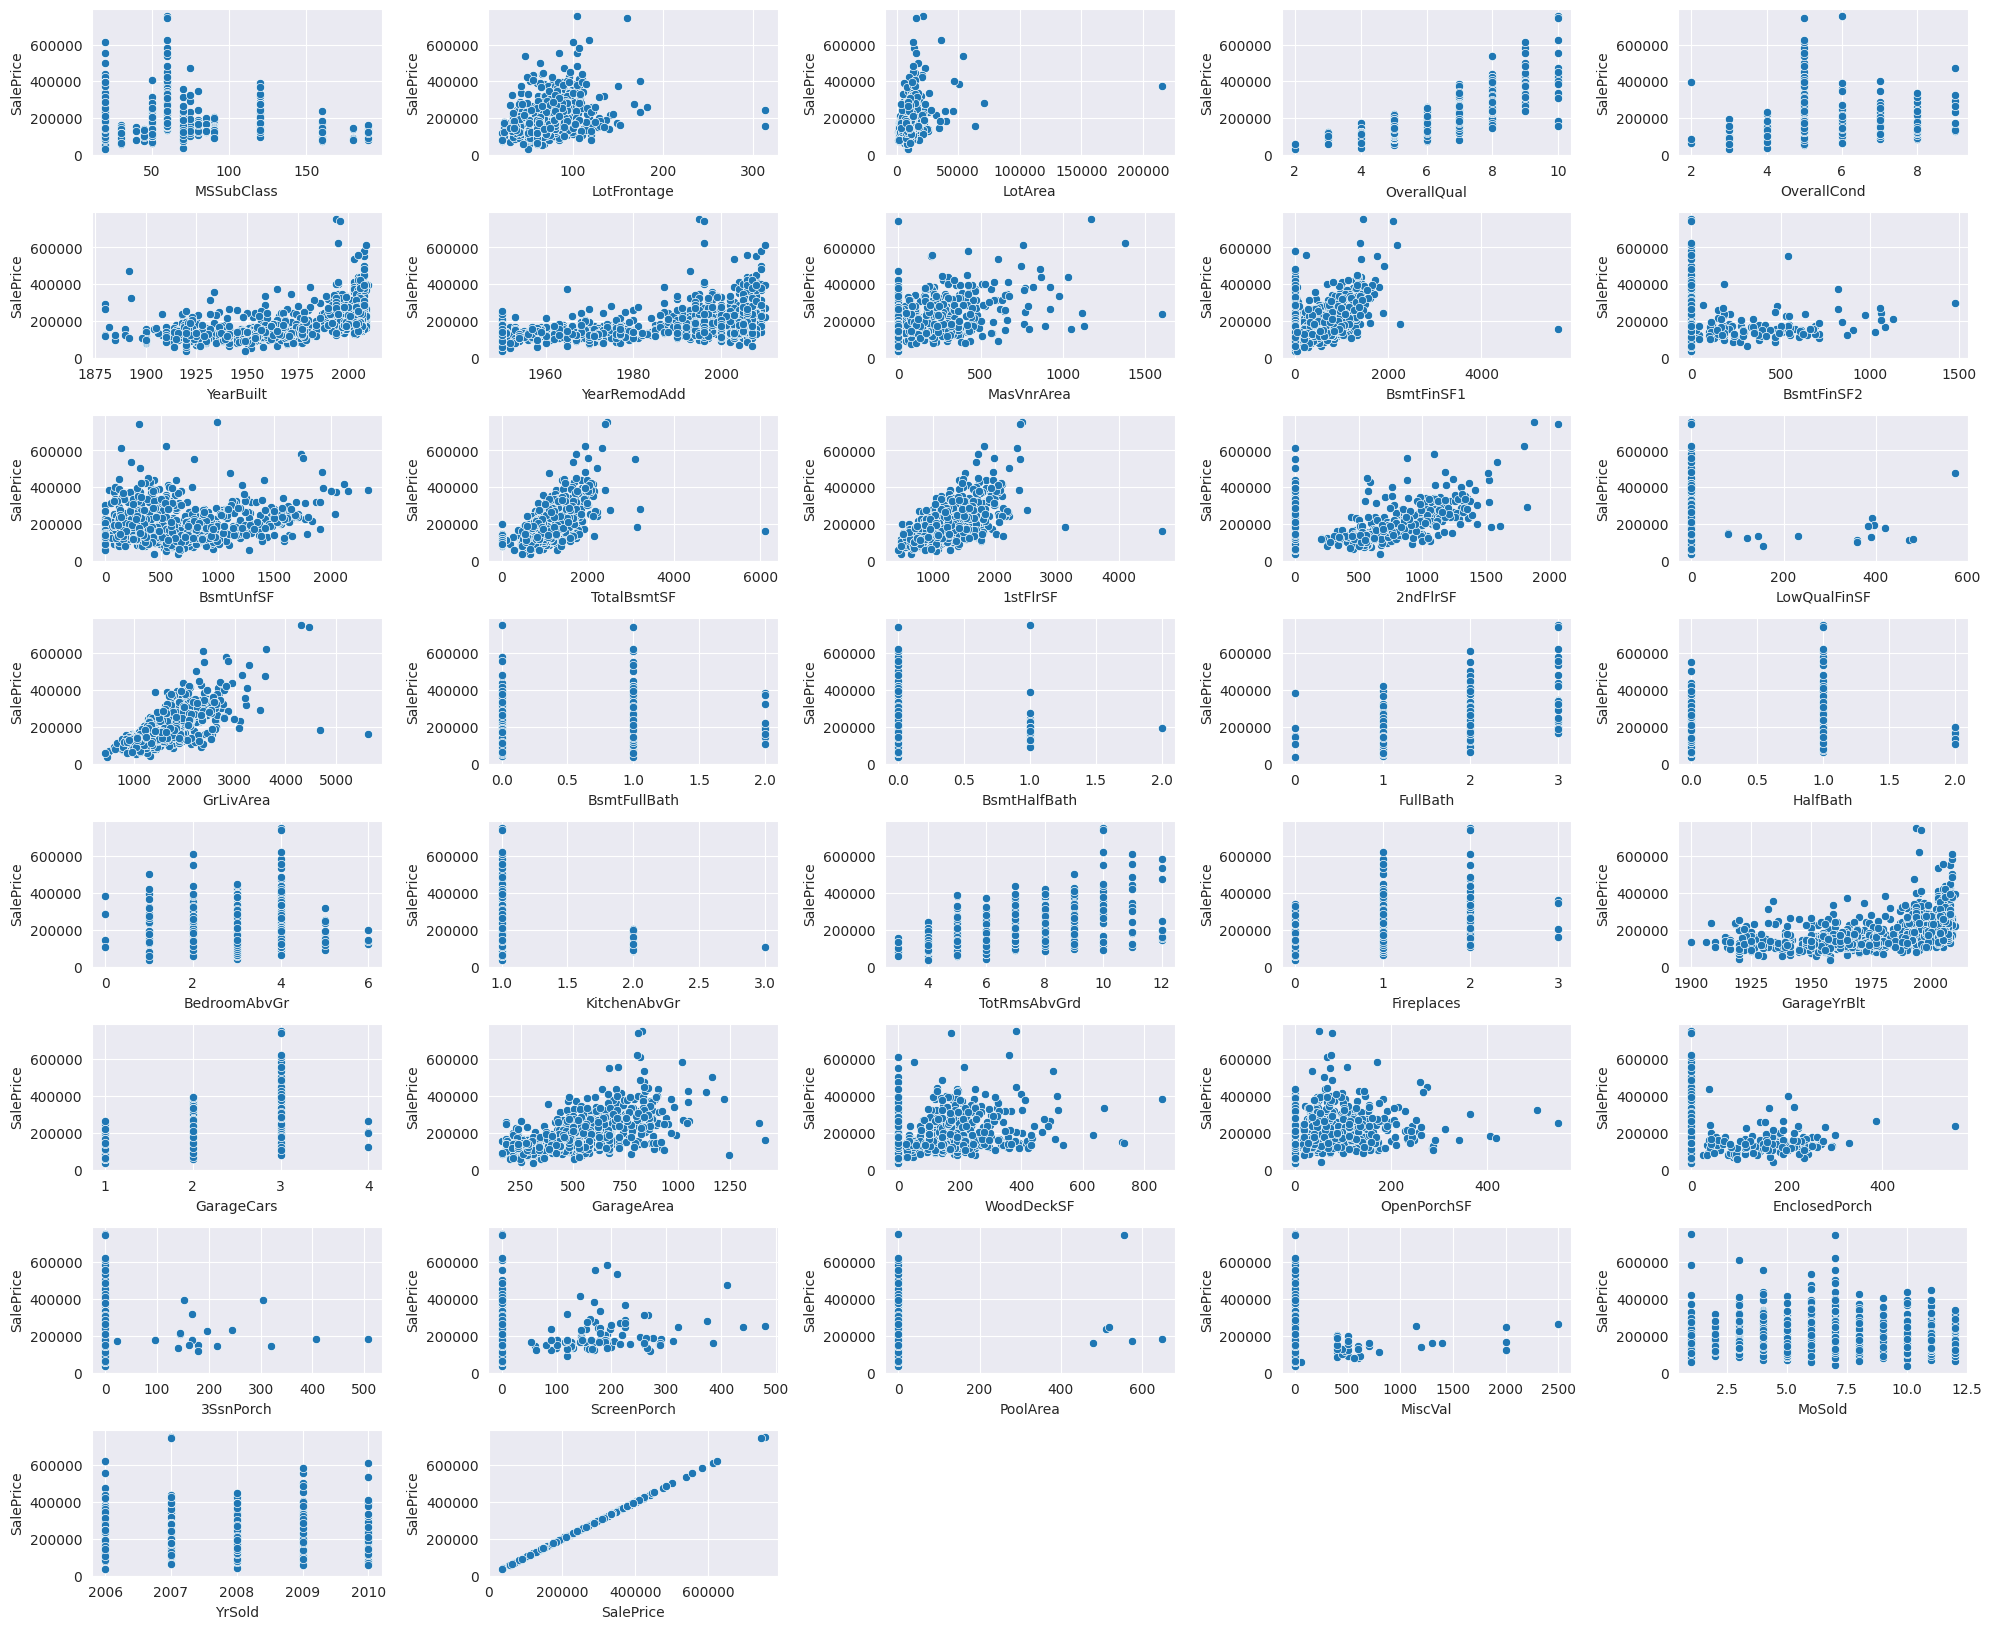

In [13]:
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train.dropna())
fig.tight_layout(pad=1.0)

## Prepare the Data

### Remove multicollinear features

In [14]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

### Handle Missing Data

,features,sum
0,PoolQC,2909
1,MiscFeature,2814
2,Alley,2721
3,Fence,2348
4,MasVnrType,1766
5,FireplaceQu,1420
6,LotFrontage,486
7,GarageFinish,159
8,GarageQual,159
9,GarageCond,159


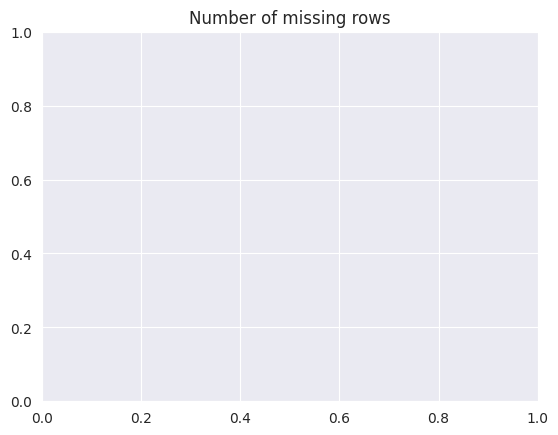

In [15]:
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
missing_count

In [16]:
X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

### Temporal feature analysis/removal

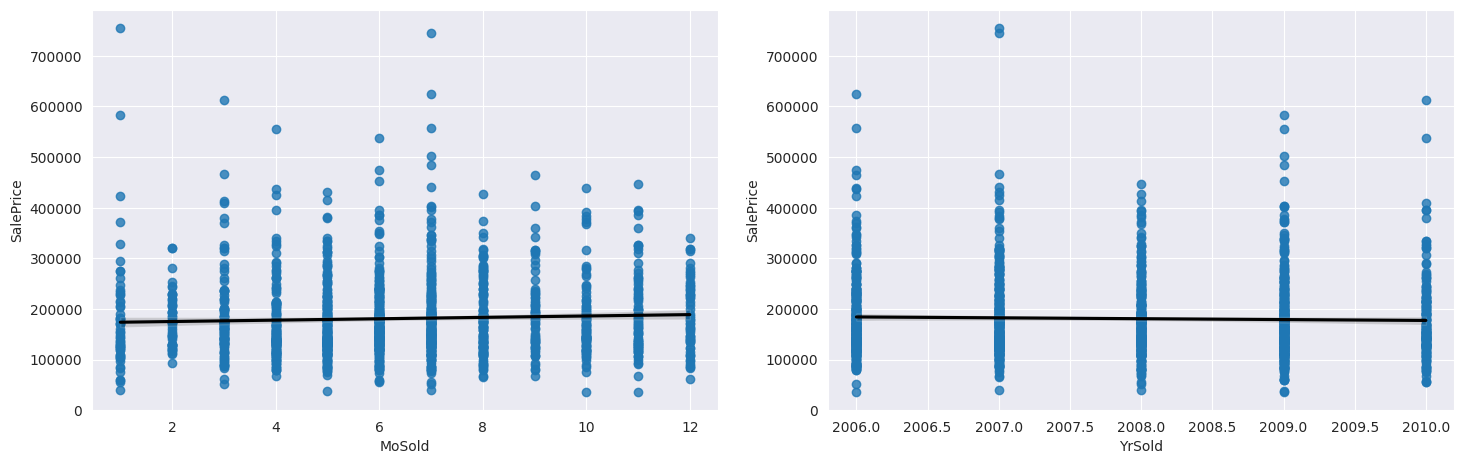

In [17]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [18]:
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False).tail(10)

X.drop(['MoSold','YrSold'], axis=1, inplace=True)

### Remove overfitted features

In [19]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

In [20]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

In [21]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


### Outlier removal

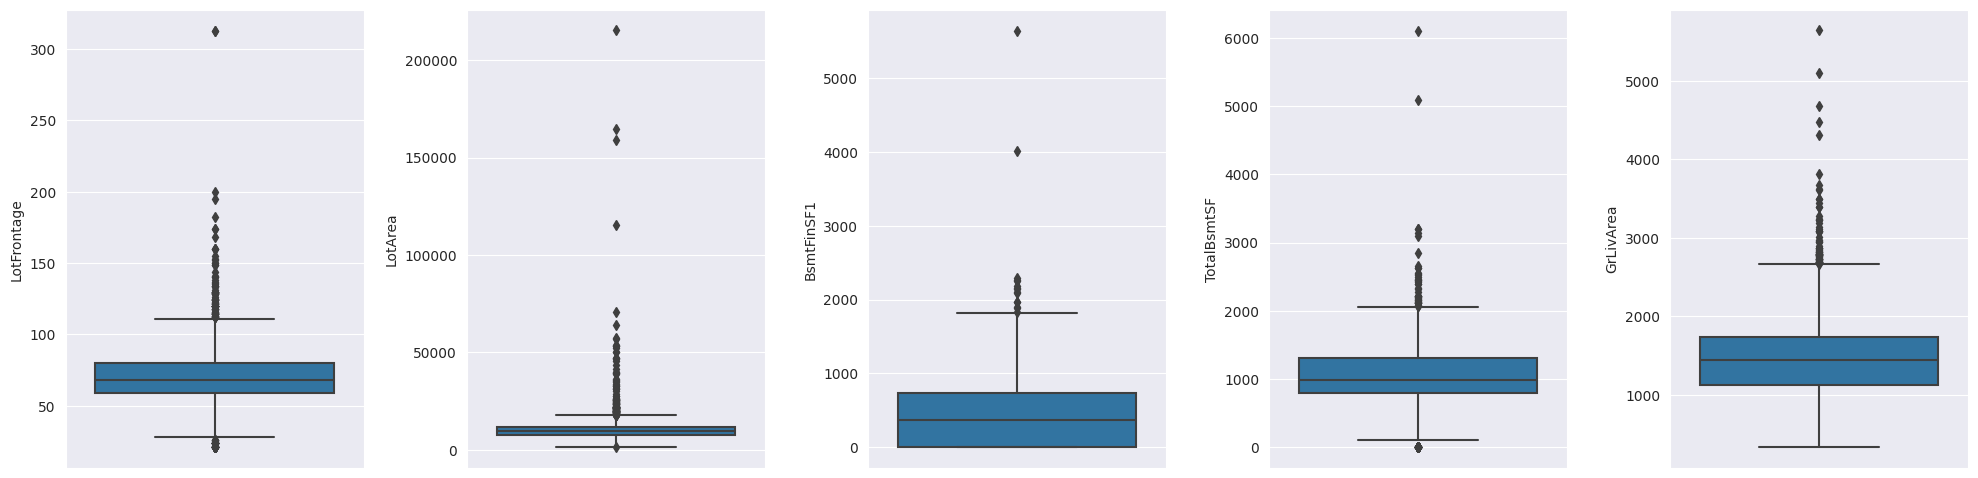

In [22]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [23]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


### Missing data imputation (categorical)

In [24]:
X.shape

(2919, 61)

In [25]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
Fence,2348
MasVnrType,1766
FireplaceQu,1420
LotFrontage,486
GarageCond,159
GarageQual,159
GarageFinish,159
GarageType,157
BsmtExposure,82
BsmtCond,82


In [26]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")

In [27]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
for col in cols:
    X[col] = X[col].fillna(X[col].mode()[0])

### Neighborhood-based imputation

In [28]:
print("Mean of LotFrontage: ", X['LotFrontage'].mean())
print("Mean of GarageArea: ", X['GarageArea'].mean())

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

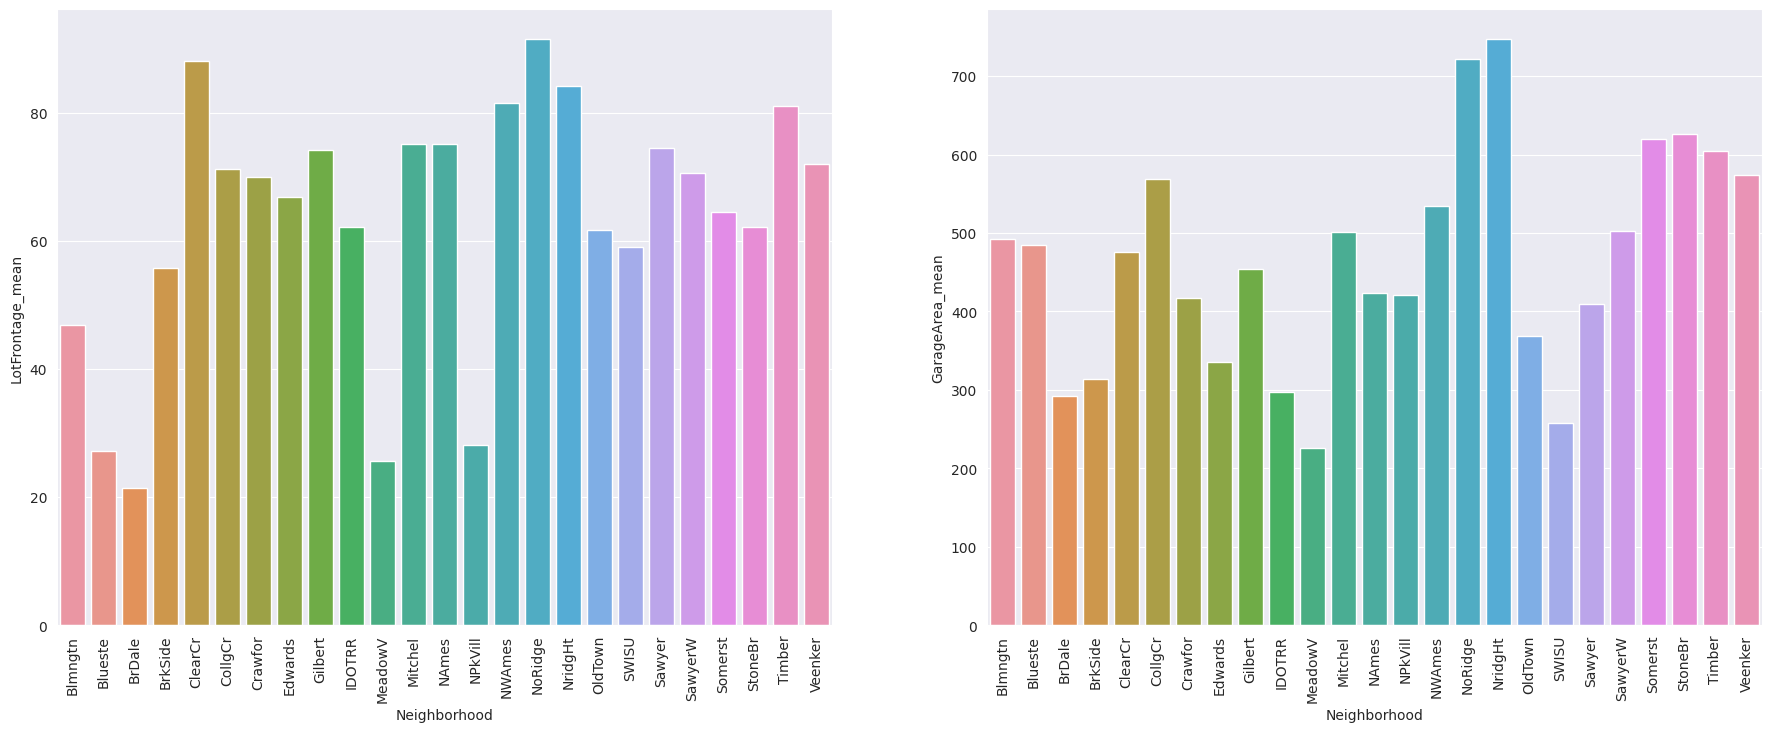

In [29]:
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [30]:
#for correlated relationship
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont] = X[cont].fillna(X[cont].mean())

In [31]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

### Ordinal encoding

In [32]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [33]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

### Feature engineering

In [34]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

### Binary threshold features

In [35]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

# Create binary columns safely using numpy where
for col in colum:
    if col in X.columns:  # Check if column exists
        new_col_name = f"{col}_binary"
        X[new_col_name] = np.where(X[col] > 0, 1, 0)

### One-hot encoding

In [36]:
X = pd.get_dummies(X)

### Target transformation

<ipython-input-37-9604e66e530a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(train['SalePrice'],norm_hist=False)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


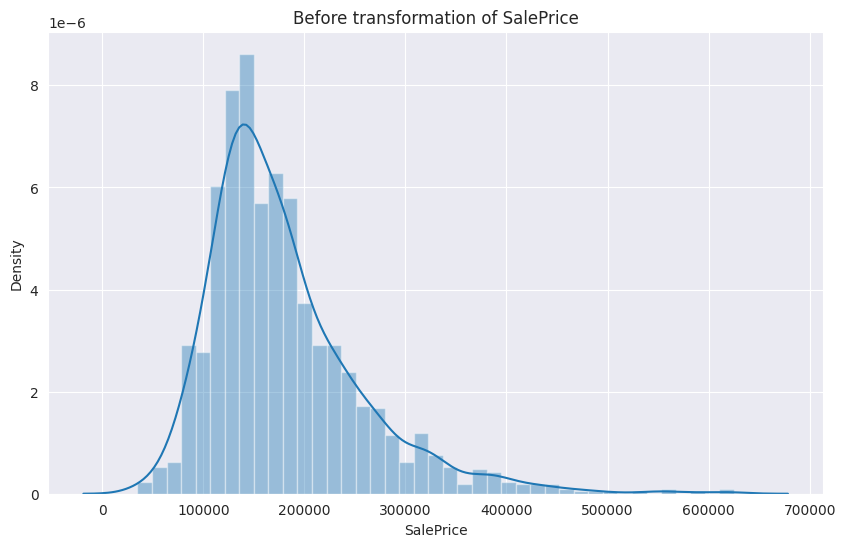

In [37]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'],norm_hist=False)

<ipython-input-38-5271bce2e7d9>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


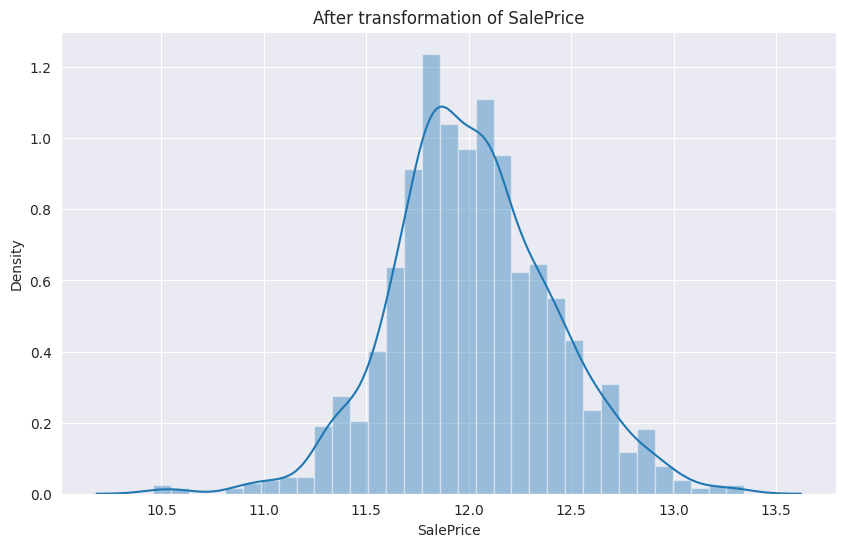

In [38]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [39]:
y["SalePrice"] = np.log(y['SalePrice'])

In [40]:
x = X.loc[train.index]
y = y.loc[train.index]
test = X.loc[test.index]

### Robust scaling

In [41]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

## Select and Train a Model

### Train/test split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2020)

### Model Imports and Base Configurations

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

In [44]:
'''
Find out more on the XGBRegressor implementation and parameters at 
https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
'''

# xgb = XGBRegressor(booster='gbtree', learning_rate=0.3, n_estimators=3460,
#                     max_depth=6, min_child_weight=1, subsample=1,
#                     gamma=0, reg_alpha = 0.001, colsample_bytree=0.7,
#                     objective='reg:squarederror', reg_lambda = 0.001,
#                     scale_pos_weight=1, seed=2020)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

### XGBoost Hyperparameter Tuning

In [45]:
from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)

In [46]:
"""
Learn more avout LightBGM parameters at 
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
"""

lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
                    lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                    n_estimators=100, max_bin=200, min_child_samples=20, 
                    bagging_fraction=0.75, bagging_freq=5,
                    bagging_seed=7, feature_fraction=0.8,
                    feature_fraction_seed=7, verbose=-1)

### LightGBM Hyperparameter Tuning

In [47]:
param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
lightgbm_search = lightgbm.fit(X_train, y_train)

# LightBGM with tuned hyperparameters
best_param = lightgbm_search.best_params_
lgbm = LGBMRegressor(**best_param)

In [48]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

### CatBoost Hyperparameter Tuning

In [49]:
param_lst = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

catboost_search = catboost.fit(X_train, y_train)

# CatBoost with tuned hyperparams
best_param = catboost_search.best_params_
cb = CatBoostRegressor(logging_level='Silent', **best_param)

## Fine-Tune Your Model

### Cross-Validation and Model Evaluation

In [50]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, x, y)


xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, x, y)


lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, x, y)

### Model Performance Comparison

In [51]:
model_performances = pd.DataFrame({
    "Model" : ["XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
      Model  CV(5)    MAE   RMSE  Score
2  CatBoost  0.915  0.071  0.102  0.928
1      LGBM  0.912  0.078  0.110  0.917
0   XGBoost  0.906  0.081  0.113  0.913


## Submit Prediction

### Ensemble Predictions

In [52]:
def blend_models_predict(X, b, c, d):
        return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

### Generate Final Submission

In [53]:
subm = np.exp(blend_models_predict(test, 0.4, 0.3, 0.3))
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': subm})

submission.to_csv("../../kaggle/working/submission.csv", index=False)